Импорт и установка нужных библиотек

In [ ]:
pip install datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Чтение уже размеченного датасета с отзывами

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/мифи семестры/1 семестр/хакатон/combined_reviews_with_labels2.xlsx', engine='openpyxl')

In [ ]:
data

,Index,Review,label
0,1,"Была на выставке Васнецовы. Люблю Третьяковку,...",1
1,2,Всё лучшее в живописи и классическом искусстве...,1
2,3,Великолепная коллекция русского авангарда. Неп...,1
3,4,Отличное культурное пространство. Были на осно...,0
4,5,"Большая, серьезная, просторная, тихая, взросла...",1
...,...,...,...
1465,593,"Современное искусство. Малевич, Кандинский, Ша...",1
1466,596,Очень понравилась выставка Васнецовых. И конеч...,1
1467,597,Атмосферное место,1
1468,598,"Была на выставкк ""Золотая черепаха"". Фото о пр...",1


Структура данных:

Индекс (столбец Index).

Текст отзыва (столбец Review).

Метка тональности (столбец label): 0 - негативный, 1 - позитивный.

# Применение исходной модели cointegrated/rubert-tiny-sentiment-balanced :

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/мифи семестры/1 семестр/хакатон/combined_reviews_with_labels2.xlsx', engine='openpyxl')
data = data[['Review', 'label']]

# Разделение на обучающую и тестовую выборки
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

# Загрузка предобученной модели и токенизатора
model_name = "cointegrated/rubert-tiny-sentiment-balanced"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Функция для предсказания тональности отзыва
def predict_sentiment(review):
    encoding = tokenizer(review, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()

    # Оставляем только два класса: 0 (Негативный) и 1 (Позитивный)
    if prediction == 2:
        # Если метка 2 (нейтральная), то можно отнести к наиболее вероятному классу
        prediction = 1 if logits[0][1] > logits[0][0] else 0

    sentiment_mapping = {0: "Негативный", 1: "Позитивный"}
    return prediction  # Вернем только метку (0 или 1)

# Прогнозирование тональности для тестовой выборки
true_labels = test_data['label'].values  # Истинные метки тестовой выборки
pred_labels = []

for review in test_data['Review']:
    pred = predict_sentiment(review)
    pred_labels.append(pred)

# Вычисление метрик: Accuracy и F1 Score
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7279
F1 Score: 0.7927


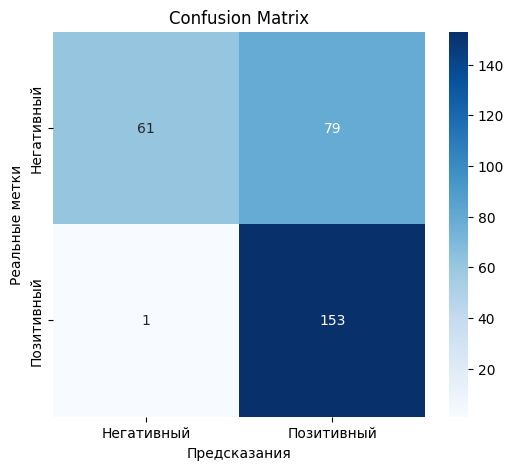

In [ ]:
# Строим confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Негативный", "Позитивный"], yticklabels=["Негативный", "Позитивный"])
plt.xlabel("Предсказания")
plt.ylabel("Реальные метки")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Вычисление precision, recall, f1
report = classification_report(true_labels, pred_labels, target_names=["Негативный", "Позитивный"], output_dict=True)

# Печать метрик для классов 0 и 1
for label in report:
    if label != 'accuracy' and label != 'macro avg' and label != 'weighted avg':
        print(f"{label}:")
        print(f"  Precision: {report[label]['precision']:.4f}")
        print(f"  Recall: {report[label]['recall']:.4f}")
        print(f"  F1 Score: {report[label]['f1-score']:.4f}")

Негативный:
  Precision: 0.9839
  Recall: 0.4357
  F1 Score: 0.6040
Позитивный:
  Precision: 0.6595
  Recall: 0.9935
  F1 Score: 0.7927


# Далее дообучим данную модель на размеченном датасете:

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/мифи семестры/1 семестр/хакатон/combined_reviews_with_labels2.xlsx', engine='openpyxl')
data = data[['Review', 'label']]

# Разделение на обучающую и тестовую выборки
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

# Балансировка классов
positive = train_data[train_data['label'] == 1]
negative = train_data[train_data['label'] == 0]

positive_undersampled = resample(positive, replace=False, n_samples=len(negative), random_state=42)
undersampled_train_data = pd.concat([positive_undersampled, negative]).sample(frac=1, random_state=42)

# Преобразование в Dataset
train_dataset = Dataset.from_pandas(undersampled_train_data[['Review', 'label']])
test_dataset = Dataset.from_pandas(test_data[['Review', 'label']])

# Модель и токенизатор
model_name = "cointegrated/rubert-tiny-sentiment-balanced"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Загрузка модели с корректировкой количества меток
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    ignore_mismatched_sizes=True  # Игнорирование несовпадения размеров
)

# Токенизация
def tokenize_function(examples):
    return tokenizer(examples["Review"], padding="max_length", truncation=True)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Настройки обучения
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
)

# Обучение
trainer.train()

# Сохранение модели
model.save_pretrained("./russian_sentiment_model")
tokenizer.save_pretrained("./russian_sentiment_model")

# Прогнозы
predictions = trainer.predict(tokenized_test)
pred_labels = predictions.predictions.argmax(axis=1)
true_labels = test_data['label'].values

# Метрики
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny-sentiment-balanced and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 312]) in the checkpoint and torch.Size([2, 312]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1118 [00:00<?, ? examples/s]

Map:   0%|          | 0/294 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-27-faf2c11e79fc>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.381700,0.339868
2,0.261300,0.278508
3,0.221200,0.273540


Accuracy: 0.9048
F1 Score: 0.9073


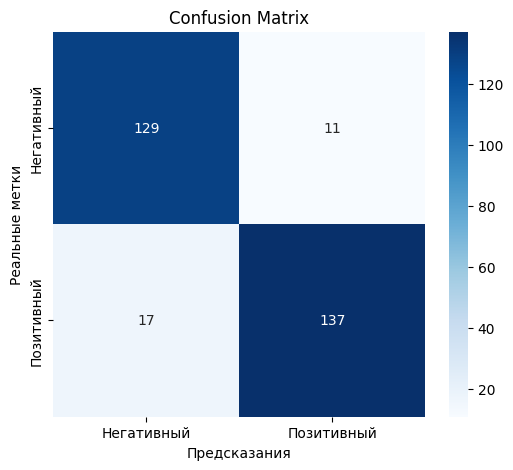

In [ ]:
# Строим confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Негативный", "Позитивный"], yticklabels=["Негативный", "Позитивный"])
plt.xlabel("Предсказания")
plt.ylabel("Реальные метки")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Вычисление precision, recall, f1
report = classification_report(true_labels, pred_labels, target_names=["Негативный", "Позитивный"], output_dict=True)

# Печать метрик для классов 0 и 1
for label in report:
    if label != 'accuracy' and label != 'macro avg' and label != 'weighted avg':
        print(f"{label}:")
        print(f"  Precision: {report[label]['precision']:.4f}")
        print(f"  Recall: {report[label]['recall']:.4f}")
        print(f"  F1 Score: {report[label]['f1-score']:.4f}")

Негативный:
  Precision: 0.8836
  Recall: 0.9214
  F1 Score: 0.9021
Позитивный:
  Precision: 0.9257
  Recall: 0.8896
  F1 Score: 0.9073


Результаты на дообученной модели имеют лучший результат, чем на исходной моделе

Теперь применим модель на отзывых не из датасета:

In [ ]:
new_reviews = [
    "Мне очень понравился этот музей, потрясающая коллекция!",
    "Интересная выставка, но я ожидал большего",
    "Музей слишком дорогой для того, что он предлагает"
]

new_encodings = tokenizer(new_reviews, padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
    outputs = model(**new_encodings)
    predictions = outputs.logits.argmax(dim=-1)

sentiment_mapping = {0: "Негативный", 1: "Позитивный"}
for review, label in zip(new_reviews, predictions):
    sentiment = sentiment_mapping[label.item()]
    print(f"Отзыв: {review} -> Тональность: {sentiment}")

Отзыв: Мне очень понравился этот музей, потрясающая коллекция! -> Тональность: Позитивный
Отзыв: Интересная выставка, но я ожидал большего -> Тональность: Негативный
Отзыв: Музей слишком дорогой для того, что он предлагает -> Тональность: Негативный


Полученный ответ является верным по исходной логике разметки